#### Initial imports

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

#### Set processing parameters

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
USE_PARALLEL = False

### Prep lists of input files

In [3]:
from glob import glob
import re
import pandas as pd
from random import sample, seed

In [4]:
encoder_list = ['resnet34']
avail_suffix = ['rgb', 'tpi', 'ndvi']

In [5]:
# set working directory
#os.chdir('/project/cper_neon_aop/cper_pdog_uas')

# set directories for training data and labels
DATA_FOLDER = './cnn_train_images_2cm/{}_{}.tif'
LABEL_FOLDER = './cnn_train_labels_2cm/{}_labels.tif'

# set parameters for each resolution
res_dict = {
    5: {'min_factor': 3,
        'max_factor': 6},
    10: {'min_factor': 2,
        'max_factor': 4},
    15: {'min_factor': 1,
        'max_factor': 3},
    30: {'min_factor': 1,
        'max_factor': 2}
}

In [6]:
# read in csvs with training information
df_tiles = pd.read_csv('train_tiles/train_bboxes_all_assigned.csv')
df_polys = pd.read_csv('train_polys/train_polys_all.csv')

In [7]:
# get all ids to be used
label_files = glob(LABEL_FOLDER.replace('{}', '*'))
all_ids = [re.sub('_labels.tif', '', os.path.basename(f)) for f in label_files]
all_tiles = list(set(['_'.join(y.split('_')[2:]) for y in all_ids]))

In [8]:
# separate training and test data and get paths to files
all_files = glob(DATA_FOLDER.replace('{}', '*'))
all_train_tiles = [x for x in df_tiles.apply(lambda x: '_'.join([x.Pasture, x.Tile]) if x.Train == 1 else '', axis=1) if x != '' and x in all_tiles]
test_tiles = list(set(all_tiles) - set(all_train_tiles))

all_train_ids = [x for x in all_ids if '_'.join(x.split('_')[-3:]) in all_train_tiles]
test_ids = list(set(all_ids) - set(all_train_ids))

seed(321)
valid_ids = sample(all_train_ids, int(np.ceil(len(all_train_ids)*0.2)))
train_ids = list(set(all_train_ids) - set(valid_ids))

train_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in train_ids]
valid_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in valid_ids]
test_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in test_ids]

In [9]:
tile_ids = df_tiles[(df_tiles['Digitize'] == 1)].apply(lambda x: '_'.join([x.Pasture, x.Tile]), axis=1)
#all_tiles#
[x for x in all_tiles if x not in tile_ids.to_list()]

[]

In [10]:
[x for x in tile_ids.to_list() if x not in all_tiles]

[]

### Dataloader
Writing helper class for data extraction, tranformation and preprocessing

In [11]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from skimage import io
from skimage.transform import resize

In [12]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        ids (list): list of unique ids for all images
        images_path (str): path to data images
        masks_path (str): path to label masks
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    
    CLASSES = ['other', 'burrow']
    
    def __init__(
            self, 
            ids,
            suffix_list,
            images_path,
            masks_path, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            suffix_dict = {
        'rgb': {'channels': 3,
                'dtype': 'uint8'},
        'tpi': {'channels': 1,
                'dtype': 'float32'},
        'dsm': {'channels': 1,
                'dtype': 'float32'},
        'shade': {'channels': 1,
                  'dtype': 'float32'},
        'ndvi': {'channels': 1,
                  'dtype': 'float32'}
    }
    ):
        # get IDs as attribute
        self.ids = ids
        
        # get suffix info
        self.suffix_dict = suffix_dict
        
        # get list of suffixes as attribute
        self.suffix_list = suffix_list
        
        # List of files
        self.images_fps = []
        self.masks_fps = [masks_path.format(id) for id in ids]
        for id in ids:
            self.images_fps.append({s: images_path.format(id, s) for s in suffix_list})
            
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image_list = []
        self.image_dict = {}
        for s in self.suffix_list:
            image_s = np.asarray(io.imread(self.images_fps[i][s]), dtype=self.suffix_dict[s]['dtype'])
            if len(image_s.shape) == 2:
                image_s = np.expand_dims(image_s, axis=-1)
            image_s[np.isnan(image_s)] = 0
            if s == 'ndvi':
                image_s[image_s < 0] = 0
            if self.preprocessing:
                image_s = normalize_fn(image_s, s, image_stats)
            image_list.append(image_s)
            self.image_dict[s] = image_s
        if len(image_list) == 1:
            image = image_list[0]
        else:
            image = np.concatenate(image_list, axis=-1)
        mask = np.asarray(io.imread(self.masks_fps[i]), dtype='float32')
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1)#.astype('float32')
        #print('fetched: ', self.ids[i])
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # convert final image arrays to tensors
        image = torch.from_numpy(image.transpose(2, 0, 1).astype('float32'))
        mask = torch.from_numpy(mask.transpose(2, 0, 1).astype('float32'))
        return image, mask
        
    def __len__(self):
        return len(self.ids)


### Augmentations

In [13]:
import albumentations as albu
import random

In [14]:
def get_training_augmentation(min_factor, max_factor):
    win_size = 32 * random.randint(min_factor, max_factor)
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomCrop(height=win_size, width=win_size, always_apply=True),

        #albu.GaussNoise(p=0.2, var_limit=1.0),
        #albu.Perspective(p=0.5),

        #albu.OneOf(
        #    [
        #        #albu.CLAHE(p=1), # required int8 images
        #        albu.RandomBrightnessContrast(p=1),
        #        #albu.RandomGamma(p=1),
        #        #albu.HueSaturationValue(p=1),
        #    ],
        #    p=0.9,
        #),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=(3, 7), p=1),
                albu.MotionBlur(blur_limit=(3, 7), p=1),
            ],
            p=0.25,
        ),
    ]
    return albu.Compose(train_transform)

### Create preprocessing function from training data stats

In [15]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import torch.nn as nn
import gc

In [16]:
mod_list = ['deeplabplus']
inputs_list = [['rgb', 'tpi', 'ndvi'], 
               ['rgb', 'tpi'],
               ['rgb', 'ndvi'],
               ['tpi'], 
               ['rgb'],
              ]

In [17]:
CLASSES = ['burrow']
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #'cuda'# 'cpu'# 
VALID_THRESH = 0.005
CYCLE_EPOCHS = 4 # must be an even number as currently coded. Should be between 4 and 16
BATCH_SIZE = 8
MIN_CYCLES = 2
MAX_EPOCHS = 64 # should be evenly divided by CYCLE_EPOCHS
CYCLE_PATIENCE = 2
#PATIENCE = 5

In [18]:
print(DEVICE)

cuda:0


In [19]:
# create function to normalize all data in range 0-1
def normalize_fn(image, image_suffix, stats_dict):
    if image_suffix in stats_dict.keys():
        min_tmp = stats_dict[image_suffix]['min']
        max_tmp = stats_dict[image_suffix]['max']
    else:
        # normalize to individual image if min/max stats not specified in dictionary
        min_tmp = np.min(image)
        max_tmp = np.max(image)
    return (image - min_tmp) / (max_tmp - min_tmp)

### Create burrow-scale validation metric

In [20]:
from segmentation_models_pytorch.utils import base
from segmentation_models_pytorch.utils import functional as F
from segmentation_models_pytorch.base.modules import Activation
from skimage.measure import label, regionprops


def f_score_burrow(pr, gt, beta=1, eps=1e-7, threshold=None, ignore_channels=None, resolution=None):
    """Calculate F-score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        beta (float): positive constant
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: F score
    """

    pr = F._threshold(pr, threshold=threshold)
    pr, gt = F._take_channels(pr, gt, ignore_channels=ignore_channels)

    gt = gt.cpu().detach().numpy().squeeze()
    pr = pr.cpu().detach().numpy().squeeze()

    # get regions and properties of the ground truth and predictions
    label_labels = label(gt)
    label_regions = regionprops(label_labels)
    pr_labels = label(pr)
    pr_regions = regionprops(pr_labels)

    precision_list = []
    for r in pr_regions:
        if r.area*resolution**2 > 0.05:
            y_pr, x_pr = r.centroid
            precision_list.append(gt[int(y_pr), int(x_pr)])
    recall_list = []
    for r in label_regions:
        y_label, x_label = r.centroid
        recall_list.append(pr[int(y_label), int(x_label)])

    if (len(precision_list) == 0) & (len(recall_list) == 0):
        score = 1.0
    else:
        precision = np.sum(precision_list) / (len(precision_list)+eps)
        recall = np.sum(recall_list) / (len(recall_list)+eps)
        score = (2 * precision * recall) / ((precision + recall)+eps)
    return torch.as_tensor(score).float().to(DEVICE)

class Fscore_burrow(base.Metric):
    __name__ = "fscore_burrow"
    def __init__(self, beta=1, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, resolution=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels
        self.resolution = resolution

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return f_score_burrow(
            y_pr,
            y_gt,
            eps=self.eps,
            beta=self.beta,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
            resolution=self.resolution
        )

### Check that augmentation and normalization are working as expected

In [21]:
res = 5

In [22]:
# load the image stats from the training data
df_image_stats = pd.read_csv('./_utils/image_stats_2cm.csv').set_index('stat')

# convert image stats dictionary to dataframe
image_stats = {i: {'min': df_image_stats.loc['min', i],
                   'max': df_image_stats.loc['max', i]} for i in df_image_stats.columns}

In [23]:
print(image_stats)

{'rgb': {'min': 0.0, 'max': 255.0}, 'tpi': {'min': -0.1, 'max': 0.4}, 'ndvi': {'min': 0.0, 'max': 1.0}}


torch.Size([3, 128, 128])


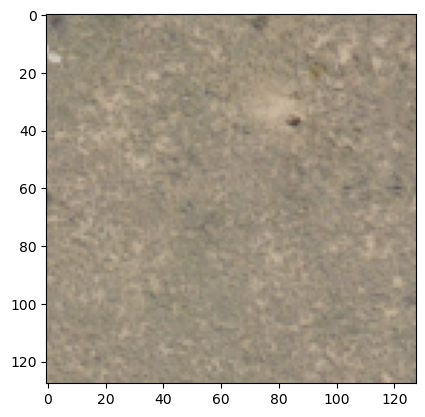

In [24]:
suffix_list = ['rgb']
train_dataset = Dataset(
        train_ids,
        suffix_list,
        re.sub('2cm', str(res) + 'cm', DATA_FOLDER),
        re.sub('2cm', str(res) + 'cm', LABEL_FOLDER),
        augmentation=get_training_augmentation(res_dict[res]['min_factor'],
                                               res_dict[res]['max_factor']),
        preprocessing=True,
        classes=CLASSES)
i = 3
img = train_dataset[i]
print(img[0].shape)
try:
    plt.imshow(img[0].cpu().numpy().squeeze())
except TypeError:
    plt.imshow(img[0].cpu().numpy().transpose(1, 2, 0))

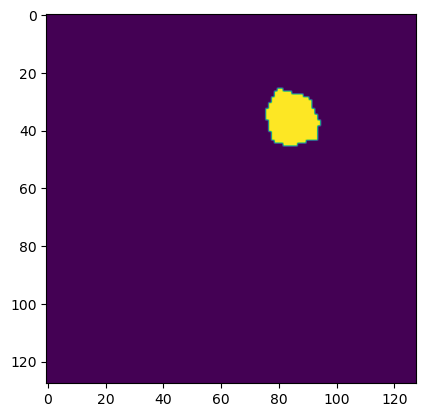

In [25]:
plt.imshow(img[1].cpu().numpy().squeeze())

In [26]:
#lr_list = np.sort([0.1**i for i in range(0, 5)])
lr_list = [0.01, 0.05, 0.07, 0.85, 0.09, 0.10, 0.25, 0.45, 0.6, 1.0]
lr_list = list(dict.fromkeys(lr_list))
lr_list

[0.01, 0.05, 0.07, 0.85, 0.09, 0.1, 0.25, 0.45, 0.6, 1.0]

In [27]:
test_lr = False
if test_lr:
    df_out = pd.DataFrame(columns=['model', 'LR', 'F-score'])
    idx_i = 0
    for res in res_dict:
        #res = 5
        print('\n\n----------------------------------------------------------')
        print('Running learning rate tests for RESOLUTION = ' + str(res) + ' cm')

        ### Create and train model

        for mod in ['deeplabplus']:
            print('\n\n----------------------------------------------------------')
            print('----------------------------------------------------------')
            print('Now running model: ' + mod)
            print('----------------------------------------------------------')
            for suffix_sub in [['rgb', 'tpi', 'ndvi']]:
                for opt_method in ['sgd']:
                    for wd in [10e-4]:
                        for mom in [0.3, 0.6, 0.9]:
                            suffix_list = list(suffix_sub)
                            print('\n\n----------------------------------------------------------')
                            print(suffix_list)
                            train_dataset = Dataset(
                                train_ids,
                                suffix_list,
                                re.sub('2cm', str(res) + 'cm', DATA_FOLDER),
                                re.sub('2cm', str(res) + 'cm', LABEL_FOLDER),
                                augmentation=get_training_augmentation(res_dict[res]['min_factor'],
                                                                       res_dict[res]['max_factor']),
                                preprocessing=True,
                                classes=CLASSES)

                            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                                      drop_last=True, num_workers=8, pin_memory=False)

                            valid_dataset = Dataset(
                                valid_ids,
                                suffix_list,
                                re.sub('2cm', str(res) + 'cm', DATA_FOLDER),
                                re.sub('2cm', str(res) + 'cm', LABEL_FOLDER),
                                preprocessing=True,
                                classes=CLASSES)

                            valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=False)

                            for lr_i in lr_list:
                                # create segmentation model with pretrained encoder
                                if mod == 'deeplabplus':
                                    model = smp.DeepLabV3Plus(
                                        encoder_name=ENCODER, 
                                        encoder_weights=ENCODER_WEIGHTS, 
                                        classes=len(CLASSES), 
                                        activation=ACTIVATION,
                                        in_channels=train_dataset[0][0].shape[0],
                                    )
                                elif mod == 'fpn':
                                    model = smp.FPN(
                                        encoder_name=ENCODER, 
                                        encoder_weights=ENCODER_WEIGHTS, 
                                        classes=len(CLASSES), 
                                        activation=ACTIVATION,
                                        in_channels=train_dataset[0][0].shape[0],
                                    )
                                elif mod == 'manet':
                                    model = smp.MAnet(
                                        encoder_name=ENCODER, 
                                        encoder_weights=ENCODER_WEIGHTS, 
                                        classes=len(CLASSES), 
                                        activation=ACTIVATION,
                                        in_channels=train_dataset[0][0].shape[0],
                                    )
                                elif mod == 'unetplus':
                                    model = smp.UnetPlusPlus(
                                        encoder_name=ENCODER, 
                                        encoder_weights=ENCODER_WEIGHTS, 
                                        classes=len(CLASSES), 
                                        activation=ACTIVATION,
                                        in_channels=train_dataset[0][0].shape[0],
                                    )
                                else:
                                    print('ERROR: model "' + mod + '" not found!')
                                    break

                                if USE_PARALLEL:
                                    model = nn.DataParallel(model)

                                preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

                                # Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
                                # IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

                                loss = smp.losses.MCCLoss()
                                loss.__name__ = 'mccloss'
                                #loss = torch.nn.BCELoss()
                                #loss.__name__ = 'bceloss'
                                metrics = [
                                    utils.metrics.IoU(threshold=0.5),
                                    utils.metrics.Accuracy(threshold=0.5),
                                    utils.metrics.Precision(threshold=0.5),
                                    utils.metrics.Recall(threshold=0.5),
                                    utils.metrics.Fscore(threshold=0.5)
                                ]

                                if opt_method == 'sgd':
                                    optimizer = torch.optim.SGD([ 
                                        dict(params=model.parameters(), lr=lr_i, momentum=mom, weight_decay=wd),
                                    ])
                                elif opt_method == 'adam':
                                    optimizer = torch.optim.Adam([
                                        dict(params=model.parameters(), lr=lr_i, momentum=mom, weight_decay=wd)
                                    ])

                                # create epoch runners 
                                # it is a simple loop of iterating over dataloader`s samples
                                train_epoch = utils.train.TrainEpoch(
                                    model, 
                                    loss=loss, 
                                    metrics=metrics, 
                                    optimizer=optimizer,
                                    device=DEVICE,
                                    verbose=True,
                                )

                                valid_epoch = utils.train.ValidEpoch(
                                    model, 
                                    loss=loss, 
                                    metrics=metrics, 
                                    device=DEVICE,
                                    verbose=True,
                                )

                                # train model for 5 epochs

                                max_score = 0
                                max_score_train = 0
                                no_improve = 0

                                print('-----------------------')
                                print('LR = ' + str(lr_i))
                                for i in range(1, CYCLE_EPOCHS * 2 + 1):
                                    print('\nEpoch: {}'.format(i))
                                    train_logs = train_epoch.run(train_loader)
                                    train_logs['fscore_old'] = train_logs['fscore']
                                    beta = 1.0
                                    train_logs['fscore'] = ((1 + beta) * train_logs['recall'] * train_logs['precision']) / (train_logs['recall'] + beta * train_logs['precision'])
                                valid_logs = valid_epoch.run(valid_loader)
                                valid_logs['fscore_old'] = valid_logs['fscore']
                                valid_logs['fscore'] = ((1 + beta) * valid_logs['recall'] * valid_logs['precision']) / (valid_logs['recall'] + beta * valid_logs['precision'])

                                df_tmp = pd.DataFrame({
                                    'model': mod,
                                    'LR': lr_i,
                                    'WD': wd,
                                    'momentum': mom,
                                    'optim': opt_method,
                                    'train_fscore': train_logs['fscore'],
                                    'train_loss': train_logs['mccloss'],
                                    'test_fscore': valid_logs['fscore'],
                                    'test_loss': valid_logs['mccloss'],
                                    'resolution': res,
                                    'inputs': '_'.join(suffix_sub),
                                }, index=[idx_i])
                                df_out = pd.concat([df_out, df_tmp])
                                idx_i += 1


                                del model, train_epoch
                                gc.collect()
                                torch.cuda.empty_cache()
                            df_out.to_csv('./_utils/lr_step_testing_downscaled.csv', index=False)

In [28]:
res_dict_lr = {
    5: {'min_lr': 0.10/4.0,
        'max_lr': 0.10},
    10: {'min_lr': 0.10/4.0,
         'max_lr': 0.10},
    15: {'min_lr': 0.10/4.0,
         'max_lr': 0.10},
    30: {'min_lr': 0.10/4.0,
         'max_lr': 0.10}
}

In [29]:
for res in res_dict:
#res = 5
    print('\n\n----------------------------------------------------------')
    print('Running all models for RESOLUTION = ' + str(res) + ' cm')
    df_loss_out = pd.DataFrame(columns=['model', 'inputs', 'resolution', 'LR', 'mccloss', 'F-score', 'IOU-score',
                                     'mccloss_val', 'F-score_val', 'IOU-score_val', 'Precision_val', 'Recall_val',])
    ### Create and train model
    
    for mod in mod_list:
        print('----------------------------------------------------------')
        print('Now running model: ' + mod)
        print('----------------------------------------------------------')
        outDIR = './cnn_results_' + mod + '_' + str(res) + 'cm/'
        if not os.path.exists(outDIR):
            os.mkdir(outDIR)
        for suffix_list in inputs_list:
            print('----------------------------------------------------------')
            print(suffix_list)
            if os.path.exists(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt'):
                print('skipping - already trained.')
                continue
            else:
                train_dataset = Dataset(
                    train_ids,
                    suffix_list,
                    re.sub('2cm', str(res) + 'cm', DATA_FOLDER),
                    re.sub('2cm', str(res) + 'cm', LABEL_FOLDER),
                    augmentation=get_training_augmentation(res_dict[res]['min_factor'],
                                                           res_dict[res]['max_factor']),
                    preprocessing=True,
                    classes=CLASSES)

                valid_dataset = Dataset(
                    valid_ids,
                    suffix_list,
                    re.sub('2cm', str(res) + 'cm', DATA_FOLDER),
                    re.sub('2cm', str(res) + 'cm', LABEL_FOLDER),
                    preprocessing=True,
                    classes=CLASSES)


                train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                      drop_last=True, num_workers=8, pin_memory=False)
                valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=False)

                # create segmentation model with pretrained encoder
                if mod == 'deeplabplus':
                    model = smp.DeepLabV3Plus(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                elif mod == 'fpn':
                    model = smp.FPN(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                elif mod == 'manet':
                    model = smp.MAnet(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                elif mod == 'unetplus':
                    model = smp.UnetPlusPlus(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                else:
                    print('ERROR: model "' + mod + '" not found!')
                    break

                if USE_PARALLEL:
                    model = nn.DataParallel(model)

                preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

                # Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
                # IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

                loss = smp.losses.MCCLoss()
                loss.__name__ = 'mccloss'
                #loss = torch.nn.BCELoss()
                #loss.__name__ = 'bceloss'
                metrics = [
                    utils.metrics.IoU(threshold=0.5),
                    utils.metrics.Accuracy(threshold=0.5),
                    utils.metrics.Precision(threshold=0.5),
                    utils.metrics.Recall(threshold=0.5),
                    utils.metrics.Fscore(threshold=0.5)
                ]
                
                metrics_val = metrics + [Fscore_burrow(threshold=0.5, resolution=res)]
                

                #optimizer = torch.optim.Adam([ 
                #    dict(params=model.parameters(), lr=0.0001),
                #])

                optimizer = torch.optim.SGD([ 
                    dict(params=model.parameters(), lr=res_dict_lr[res]['max_lr']),
                ])

                #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=10e-3, 
                #                                                steps_per_epoch=len(train_loader), epochs=MAX_EPOCHS,
                #                                                three_phase=True,
                #                                                verbose=False)

                scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=res_dict_lr[res]['min_lr'], max_lr=res_dict_lr[res]['max_lr'],
                                                              step_size_up=np.floor(len(train_dataset) / BATCH_SIZE) * CYCLE_EPOCHS / 2,
                                                              base_momentum=0.0, max_momentum=0.45,
                                                              mode='triangular2')

                # create epoch runners 
                # it is a simple loop of iterating over dataloader`s samples
                train_epoch = utils.train.TrainEpoch(
                    model, 
                    loss=loss, 
                    metrics=metrics, 
                    optimizer=optimizer,
                    oclr_scheduler=scheduler,
                    device=DEVICE,
                    verbose=True,
                )

                valid_epoch = utils.train.ValidEpoch(
                    model, 
                    loss=loss, 
                    metrics=metrics_val, 
                    device=DEVICE,
                    verbose=True,
                )

                # train model for up to 60 epochs

                max_score = 0
                max_score_train = 0
                no_improve = 0
                for i in range(1, MAX_EPOCHS+1):
                    print('\nEpoch: {}'.format(i))
                    print('Learning rate: ' + str(optimizer.param_groups[0]['lr']))
                    train_logs = train_epoch.run(train_loader)
                    beta = 1.0
                    train_logs['fscore_old'] = train_logs['fscore']
                    train_logs['fscore'] = ((1 + beta) * train_logs['recall'] * train_logs['precision']) / (train_logs['recall'] + beta * train_logs['precision'])
                    valid_logs = valid_epoch.run(valid_loader)
                    valid_logs['fscore_old'] = valid_logs['fscore']
                    valid_logs['fscore'] = ((1 + beta) * valid_logs['recall'] * valid_logs['precision']) / (valid_logs['recall'] + beta * valid_logs['precision'])

                    df_loss_tmp = pd.DataFrame({
                        'model': mod,
                        'inputs': '_'.join(suffix_list),
                        'resolution': res,
                        'LR': optimizer.param_groups[0]['lr'],
                        'mccloss': train_logs['mccloss'], 
                        'F-score': train_logs['fscore'],
                        'IOU-score': train_logs['iou_score'],
                        'mccloss_val': valid_logs['mccloss'],
                        'F-score_val': valid_logs['fscore'],
                        'F-score_val_burrow': valid_logs['fscore_burrow'],
                        'IOU-score_val': valid_logs['iou_score'],
                        'Precision_val': valid_logs['precision'],
                        'Recall_val': valid_logs['recall'],
                    }, index=[i])
                    df_loss_out = pd.concat([df_loss_out, df_loss_tmp])
                    df_loss_out['F-score_val_mvav'] = df_loss_out.groupby(['model',
                                                                           'inputs',
                                                                           'resolution'])['F-score_val'].transform(
                        lambda x: x.rolling(window=CYCLE_EPOCHS, min_periods=1).mean())
                    df_loss_out['F-score_val_burrow_mvav'] = df_loss_out.groupby(['model', 
                                                                                  'inputs', 
                                                                                  'resolution'])['F-score_val_burrow'].transform(
                        lambda x: x.rolling(window=CYCLE_EPOCHS, min_periods=1).mean())
                    df_loss_out.to_csv('./cnn_results_deeplabplus_' + str(int(res)) + 'cm/losses.csv', index=True)

                    fscore_val_burrow_mvav = df_loss_out[(df_loss_out['model'] == mod) &
                                                         (df_loss_out['inputs'] == '_'.join(suffix_list)) &
                                                         (df_loss_out['resolution'] == res)]['F-score_val_burrow_mvav'].values[-1]

                    if (i%CYCLE_EPOCHS == 0) and (i >= (MIN_CYCLES * CYCLE_EPOCHS)):
                        if (fscore_val_burrow_mvav - max_score) > VALID_THRESH:
                            max_score = fscore_val_burrow_mvav
                            max_score_train = train_logs['fscore']
                            torch.save(model, outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm.pth')
                            valid_logs['best_epoch'] = i
                            valid_logs['resolution'] = float(res)
                            best_valid_logs = valid_logs.copy()
                            print('Model saved!')
                            no_improve = 0
                        else:
                            no_improve += 1
                            print('No improvement in ' + str(no_improve) + ' cycles. Model not saved.')

                        if no_improve >= CYCLE_PATIENCE:
                            if ((train_logs['fscore'] - max_score_train) < 0.1) & (max_score > 0.6):
                                print('More than ' + str(CYCLE_PATIENCE) + ' cycles without validation improvement while training improvement < 0.1 and F-score > 0.6...ending training')
                                with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt','w') as data: 
                                    data.write(str(best_valid_logs))
                                break
                            elif no_improve == CYCLE_PATIENCE * 2:
                                print(str(CYCLE_PATIENCE * 2) + ' cycles without validation improvement...ending training')
                                with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt','w') as data: 
                                    data.write(str(best_valid_logs))
                                break

                    if i == MAX_EPOCHS:
                        print('maximum number of epochs reached...ending training')
                        with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt','w') as data: 
                                        data.write(str(best_valid_logs))

                    """for i in range(1, 61):

                        print('\nEpoch: {}'.format(i))
                        train_logs = train_epoch.run(train_loader)
                        valid_logs = valid_epoch.run(valid_loader)
                        valid_logs['fscore_old'] = valid_logs['fscore']
                        beta = 1.0
                        valid_logs['fscore'] = ((1 + beta) * valid_logs['recall'] * valid_logs['precision']) / (valid_logs['recall'] + beta * valid_logs['precision'])
                        train_logs['fscore_old'] = train_logs['fscore']
                        beta = 1.0
                        train_logs['fscore'] = ((1 + beta) * train_logs['recall'] * train_logs['precision']) / (train_logs['recall'] + beta * train_logs['precision'])                # do something (save model, change lr, etc.)

                        # do something (save model, change lr, etc.)
                        if max_score < valid_logs['fscore']:
                            max_score = valid_logs['fscore']
                            max_score_train = train_logs['fscore']
                            torch.save(model, outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm.pth')
                            valid_logs['best_epoch'] = i
                            valid_logs['resolution'] = float(res)
                            best_valid_logs = valid_logs.copy()
                            print('Model saved!')
                            no_improve = 0
                        else:
                            no_improve += 1
                            print('No improvement in ' + str(no_improve) + ' epochs. Model not saved.')

                        if i > 15:
                            if no_improve >= 5:
                                if (train_logs['fscore'] - max_score_train) < 0.05:
                                    print('More than 5 epochs without validation improvement while learning rate <= 1e-5 and training improvement < 0.05...ending training')
                                    with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt','w') as data: 
                                        data.write(str(best_valid_logs))
                                    break
                                elif (train_logs['fscore'] - max_score_train) < 0.15 and no_improve == 15:
                                    print('15 epochs without validation improvement while learning rate <= 1e-5...ending training')
                                    with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt','w') as data: 
                                        data.write(str(best_valid_logs))
                                    break
                        if i == 60:
                            with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt','w') as data: 
                                        data.write(str(best_valid_logs))

                        if i%15 == 0:
                            no_improve = 0
                            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.1
                            print('Decrease decoder learning rate by factor of 10')"""

                del model, train_epoch, valid_epoch
                gc.collect()
                torch.cuda.empty_cache()
    del df_loss_out



----------------------------------------------------------
Running all models for RESOLUTION = 5 cm
----------------------------------------------------------
Now running model: deeplabplus
----------------------------------------------------------
----------------------------------------------------------
['rgb', 'tpi', 'ndvi']
skipping - already trained.
----------------------------------------------------------
['rgb', 'tpi']
skipping - already trained.
----------------------------------------------------------
['rgb', 'ndvi']
skipping - already trained.
----------------------------------------------------------
['tpi']
skipping - already trained.
----------------------------------------------------------
['rgb']
skipping - already trained.


----------------------------------------------------------
Running all models for RESOLUTION = 10 cm
----------------------------------------------------------
Now running model: deeplabplus
---------------------------------------------------

In [30]:
print('All processing complete!')

All processing complete!


In [31]:
res = 15
df_loss_out = pd.read_csv('./cnn_results_deeplabplus_' + str(res) + 'cm/losses.csv')

In [32]:
df_loss_out = df_loss_out.rename(columns={'Unnamed: 0': 'epoch'})


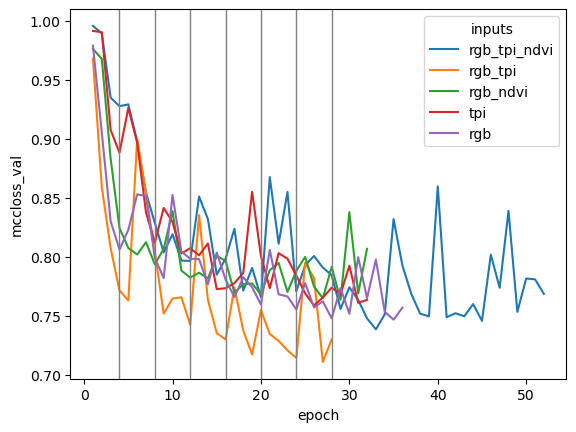

In [33]:
import seaborn as sns
p2 = sns.lineplot(x='epoch', y='mccloss_val', hue='inputs', data=df_loss_out)
#p2.set_ylim((0, 1))
for x in np.arange(4, 30, 4):
    p2.axvline(x=x, linewidth=1, color='grey')
#sns.lineplot(x='epoch', y='bceloss_val', hue='inputs', linestyle='dashed', data=df_loss_out, ax=p)
plt.show()

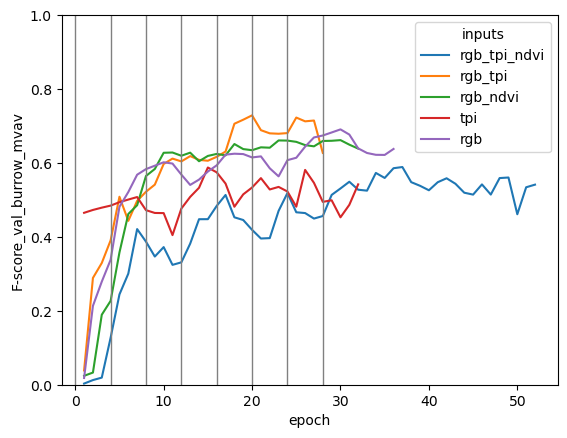

In [34]:
p2 = sns.lineplot(x='epoch', y='F-score_val_burrow_mvav', hue='inputs', data=df_loss_out)
p2.set_ylim((0, 1))
for x in np.arange(0, 30, 4):
    p2.axvline(x=x, linewidth=1, color='grey')
#sns.lineplot(x='epoch', y='bceloss_val', hue='inputs', linestyle='dashed', data=df_loss_out, ax=p)
plt.show()

In [ ]:
df_loss_out.head(5)

In [ ]:
p = sns.lineplot(x='epoch', y='bceloss', hue='inputs', data=df_loss_out)
#sns.lineplot(x='epoch', y='bceloss_val', hue='inputs', linestyle='dashed', data=df_loss_out, ax=p)
plt.show()

In [ ]:
p = sns.lineplot(x='epoch', y='bceloss_val', hue='inputs', data=df_loss_out)
#sns.lineplot(x='epoch', y='bceloss_val', hue='inputs', linestyle='dashed', data=df_loss_out, ax=p)
plt.show()

In [ ]:
p = sns.lineplot(x='epoch', y='gen_error', hue='inputs', data=df_loss_out)
#sns.lineplot(x='epoch', y='bceloss_val', hue='inputs', linestyle='dashed', data=df_loss_out, ax=p)
plt.show()